In [1]:
from google.colab import drive
drive.mount('/content/drive')

mag = 400

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install transformers

In [3]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage import io
import torch
import torch.nn as nn
from PIL import Image
from skimage.transform import resize
import numpy as np
from tqdm import tqdm
from transformers import BeitModel, BeitConfig, DeiTModel, DeiTConfig, ViTConfig, ViTModel, AutoImageProcessor
from transformers import ViTHybridModel, ViTMAEModel, ViTMSNModel
import torchvision.models as models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [4]:
!unzip -q '/content/drive/MyDrive/BreaKHis_v1/breast_cancer_breakhis.zip'

In [4]:
class BreastCancerDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df
        self.root_dir=root_dir
        self.transform=transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])

        image = io.imread(img_path)
        image = image_processor(image, return_tensors="pt")
        image = image.pixel_values.data[0]


        y_label=torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image=self.transform(image)

        return (image, y_label)

In [5]:
file_name = "df" + str(mag) + ".csv"
df = pd.read_csv(file_name)
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

In [6]:
fold_datasets = []
for train_indices, test_indices in kfold.split(df):
    train_data = df.iloc[train_indices]
    test_data = df.iloc[test_indices]

    train_dataset = BreastCancerDataset(train_data, root_dir='/content/BreaKHis_v1')
    test_dataset = BreastCancerDataset(test_data, root_dir='/content/BreaKHis_v1')

    fold_datasets.append((train_dataset, test_dataset))

In [7]:
batch_size = 20

data_loaders = []
for train_dataset, test_dataset in fold_datasets:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    data_loaders.append((train_loader, test_loader))

device=torch.device('cuda') if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

In [8]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [17]:
class NaiveInceptionModule(nn.Module):
    def __init__(self, in_channels, f1, f2, f3):
        super(NaiveInceptionModule, self).__init__()
        # 1x1 convolution
        self.conv1 = nn.Conv2d(in_channels, f1, kernel_size=1, padding=0)
        # 3x3 convolution
        self.conv3 = nn.Conv2d(in_channels, f2, kernel_size=3, padding=1)
        # 5x5 convolution
        self.conv5 = nn.Conv2d(in_channels, f3, kernel_size=5, padding=2)
        # 3x3 max pooling
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        conv1_out = torch.relu(self.conv1(x))
        conv3_out = torch.relu(self.conv3(x))
        conv5_out = torch.relu(self.conv5(x))
        pool_out = self.pool(x)
        out = torch.cat((conv1_out, conv3_out, conv5_out, pool_out), dim=1)
        return out

class VGGInception(nn.Module):
    def __init__(self, num_classes=2):
        super(VGGInception, self).__init__()
        # VGG16 base model
        self.vgg_base = models.vgg16(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.vgg_base.features.children())[:-1])
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        # Preprocess layer
        self.p1_layer = nn.Sequential(nn.Conv2d(3, 3, kernel_size=1), nn.BatchNorm2d(3))

        # Naive Inception Module
        self.inception = NaiveInceptionModule(512, 64, 128, 32)

        # Additional layers
        self.bn1 = nn.BatchNorm2d(736)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(144256, num_classes)

    def forward(self, x):
        x = self.p1_layer(x)
        x = self.feature_extractor(x)
        x = self.inception(x)
        x = self.bn1(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x

In [18]:
def test(test_loader, model, batch_size = batch_size):
  batch_size = batch_size
  predictions = []
  actual = []
  classes = ['MALIGNANT', 'BENIGN']
  with torch.no_grad():
      for images, labels in tqdm(test_loader):
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          # outputs = outputs.logits

          _, predicted = torch.max(outputs, 1)

          for i in range(labels.size(0)):
              label = labels[i]
              pred = predicted[i]
              predictions.append(pred.item())
              actual.append(label.item())

      cm = confusion_matrix(actual, predictions)

      true_positive = cm[1, 1]
      false_positive = cm[0, 1]
      false_negative = cm[1, 0]
      true_negative = cm[0, 0]
      total_correct = true_positive + true_negative
      total = true_positive + true_negative + false_positive + false_negative

      precision = true_positive / (true_positive + false_positive)
      recall = true_positive / (true_positive + false_negative)
      f1 = 2 * (precision * recall) / (precision + recall)
      accuracy = total_correct / total

      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
      disp.plot()
      plt.show()
      report = classification_report(actual, predictions, target_names=classes)
      print(report)


In [23]:
def train(train_loader, model, optimizer, loss_criteria = nn.BCELoss(), batchsize = batch_size, num_epochs = 6):
  total_step = len(train_loader)
  acc_lst = []
  loss_lst = []
  classes=[0,1]
  model = model.to(device)
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(tqdm(train_loader)):
          images = images.to(device)
          labels = F.one_hot(labels, num_classes=2)
          labels = labels.type(torch.FloatTensor)
          labels = labels.to(device)

          outputs =model(images)
          # outputs = outputs.logits
          loss = loss_criteria(outputs, labels)
          loss_lst.append(loss.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          labels =  torch.argmax(labels, dim=1)
          total = labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          acc_lst.append((correct / total) * 100)

      print('Epoch [{}/{}], Loss: {:.6f}, Accuracy:{:.2f}%'.format(epoch + 1, num_epochs, loss_lst[-1], acc_lst[-1]))

100%|██████████| 73/73 [00:56<00:00,  1.30it/s]


Epoch [1/10], Loss: 0.316538, Accuracy:87.50%


100%|██████████| 73/73 [00:51<00:00,  1.43it/s]


Epoch [2/10], Loss: 0.022878, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [3/10], Loss: 0.104463, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.42it/s]


Epoch [4/10], Loss: 0.002472, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.44it/s]


Epoch [5/10], Loss: 0.001942, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [6/10], Loss: 0.004430, Accuracy:100.00%


100%|██████████| 73/73 [00:54<00:00,  1.33it/s]


Epoch [7/10], Loss: 0.000977, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [8/10], Loss: 0.019037, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.42it/s]


Epoch [9/10], Loss: 0.041524, Accuracy:100.00%


100%|██████████| 73/73 [00:53<00:00,  1.35it/s]


Epoch [10/10], Loss: 0.005883, Accuracy:100.00%
=====================================================STEP : 1/5 COMPLETE=====================================================
TEST RESULTS :


100%|██████████| 19/19 [00:10<00:00,  1.79it/s]


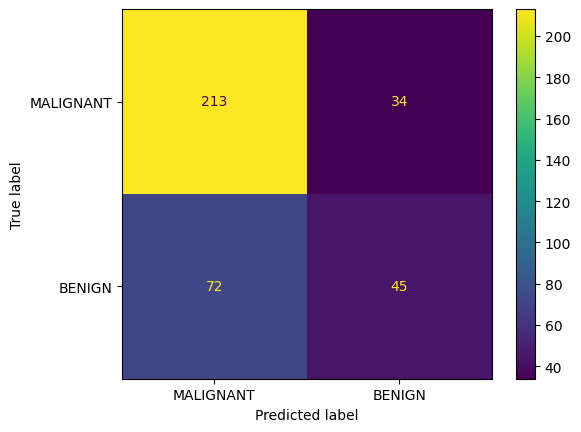

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


              precision    recall  f1-score   support

   MALIGNANT       0.75      0.86      0.80       247
      BENIGN       0.57      0.38      0.46       117

    accuracy                           0.71       364
   macro avg       0.66      0.62      0.63       364
weighted avg       0.69      0.71      0.69       364



100%|██████████| 73/73 [00:51<00:00,  1.43it/s]


Epoch [1/10], Loss: 0.815458, Accuracy:81.25%


100%|██████████| 73/73 [00:51<00:00,  1.42it/s]


Epoch [2/10], Loss: 0.015567, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [3/10], Loss: 0.010211, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.43it/s]


Epoch [4/10], Loss: 0.014244, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.44it/s]


Epoch [5/10], Loss: 0.013819, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.44it/s]


Epoch [6/10], Loss: 0.002757, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.43it/s]


Epoch [7/10], Loss: 0.016030, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [8/10], Loss: 0.019599, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.43it/s]


Epoch [9/10], Loss: 0.000979, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.44it/s]


Epoch [10/10], Loss: 0.003142, Accuracy:100.00%
=====================================================STEP : 2/5 COMPLETE=====================================================
TEST RESULTS :


100%|██████████| 19/19 [00:10<00:00,  1.82it/s]


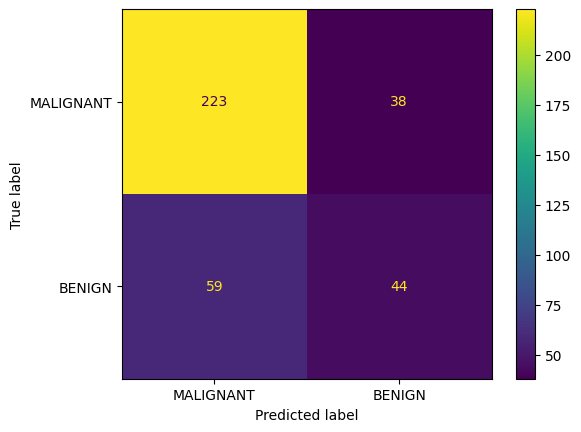

              precision    recall  f1-score   support

   MALIGNANT       0.79      0.85      0.82       261
      BENIGN       0.54      0.43      0.48       103

    accuracy                           0.73       364
   macro avg       0.66      0.64      0.65       364
weighted avg       0.72      0.73      0.72       364



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [1/10], Loss: 0.517860, Accuracy:81.25%


100%|██████████| 73/73 [00:50<00:00,  1.44it/s]


Epoch [2/10], Loss: 0.107659, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.43it/s]


Epoch [3/10], Loss: 0.039031, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.46it/s]


Epoch [4/10], Loss: 0.055323, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.43it/s]


Epoch [5/10], Loss: 0.004147, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [6/10], Loss: 0.006227, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.46it/s]


Epoch [7/10], Loss: 0.027613, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.42it/s]


Epoch [8/10], Loss: 0.000902, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [9/10], Loss: 0.082731, Accuracy:93.75%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [10/10], Loss: 0.009944, Accuracy:100.00%
=====================================================STEP : 3/5 COMPLETE=====================================================
TEST RESULTS :


100%|██████████| 19/19 [00:10<00:00,  1.85it/s]


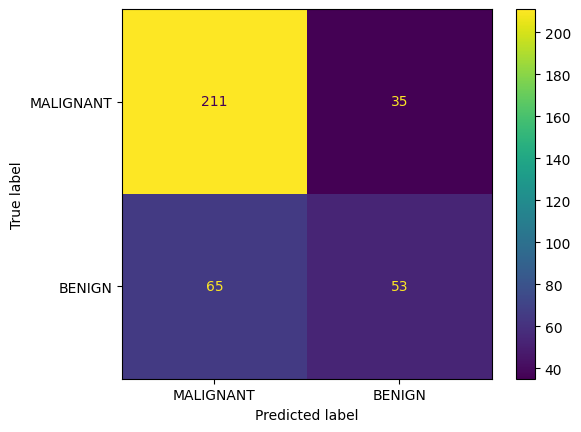

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


              precision    recall  f1-score   support

   MALIGNANT       0.76      0.86      0.81       246
      BENIGN       0.60      0.45      0.51       118

    accuracy                           0.73       364
   macro avg       0.68      0.65      0.66       364
weighted avg       0.71      0.73      0.71       364



100%|██████████| 73/73 [00:52<00:00,  1.40it/s]


Epoch [1/10], Loss: 0.542426, Accuracy:75.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [2/10], Loss: 0.184849, Accuracy:93.75%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [3/10], Loss: 0.017415, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.42it/s]


Epoch [4/10], Loss: 0.174024, Accuracy:93.75%


100%|██████████| 73/73 [00:50<00:00,  1.44it/s]


Epoch [5/10], Loss: 0.009238, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.43it/s]


Epoch [6/10], Loss: 0.087510, Accuracy:93.75%


100%|██████████| 73/73 [00:50<00:00,  1.44it/s]


Epoch [7/10], Loss: 0.029198, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.46it/s]


Epoch [8/10], Loss: 0.028613, Accuracy:100.00%


100%|██████████| 73/73 [00:51<00:00,  1.42it/s]


Epoch [9/10], Loss: 0.000958, Accuracy:100.00%


100%|██████████| 73/73 [00:50<00:00,  1.45it/s]


Epoch [10/10], Loss: 0.009809, Accuracy:100.00%
=====================================================STEP : 4/5 COMPLETE=====================================================
TEST RESULTS :


100%|██████████| 19/19 [00:10<00:00,  1.76it/s]


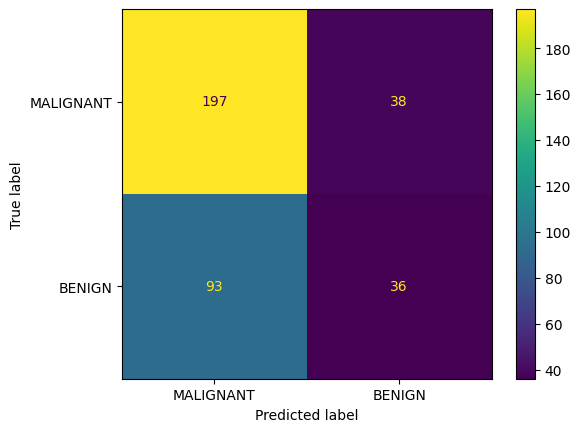

              precision    recall  f1-score   support

   MALIGNANT       0.68      0.84      0.75       235
      BENIGN       0.49      0.28      0.35       129

    accuracy                           0.64       364
   macro avg       0.58      0.56      0.55       364
weighted avg       0.61      0.64      0.61       364



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 30%|███       | 22/73 [00:15<00:36,  1.41it/s]


KeyboardInterrupt: ignored

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for fold_idx, (train_loader, test_loader) in enumerate(data_loaders):
    model = VGGInception(num_classes=2).to(device)
    optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
    optimizer.zero_grad()

    train(train_loader, model, optimizer, num_epochs = 7)
    print("=====================================================STEP : {}/{} COMPLETE=====================================================".format(fold_idx + 1, num_folds))
    print("TEST RESULTS :")
    test(test_loader, model)